In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# HELPER FUNCTION - LOAD A TURBULENCE BOX
def LoadTurbulenceBox(Datafile, Nx, Ny, Nz, FileFormat = 'Hawc2'):
    import numpy as np
    if FileFormat == 'Hawc2':
        data = np.fromfile(Datafile,dtype = 'single').reshape((Nx,Ny,Nz))
    return data

In [36]:
# HELPER FUNCTION - GENERATE A TURBULENCE BOX
def GenerateBox(SamplePointRange, SampleData, SeedRange = None):
    from hipersim.turbgen import turbgen
    
    Nboxes = len(SamplePointRange)
    if SeedRange is None:
        SeedRange = np.arange(1,Nboxes+1,1,dtype = 'int')
                

    T = turbgen.turb_field(dy = 8.0, dz = 8.0, BaseName = 'turb', SaveToFile = 0, alphaepsilon = 0.1)
    for i in (range(len(SeedRange))):
        iseed = SeedRange[i]
        isample = SamplePointRange[i]
        print('Seed no. ' + str(iseed))
        T.params['dx'] = SampleData['turb_dx'][isample]
        T.params['SeedNo'] = iseed
        T.params['SaveToFile'] = 0
        T.TurbOptions = {'FileFormat': 0,
                         'zHub': 150,
                         'Umean': SampleData['U[m/s]'][isample],
                         'alpha': SampleData['Alpha'][isample],
                         'TI_u': (SampleData['SigmaU[m/s]'][isample])/(SampleData['U[m/s]'][isample]),
                         'TI_v': 0.8*(SampleData['SigmaU[m/s]'][isample])/(SampleData['U[m/s]'][isample]),
                         'TI_w': 0.5*(SampleData['SigmaU[m/s]'][isample])/(SampleData['U[m/s]'][isample]),
                         'Yaw': SampleData['Yaw[deg]'][isample]}
        T.generate()
        T.params['SaveToFile'] = 1
        T.output()

In [3]:
# HELPER FUNCTION - MOVING AVERAGE INCLUDING POSSIBILITY FOR NONLINEAR WEIGHTING
def MovingAverage(x,span, method = 'center',WeightFunction = None):
    nx = len(x)
    xl = np.pad(x, (span, span), 'edge')
    spanmatrix = np.repeat(np.atleast_2d(xl).T,span,axis = 1)

    for i in range(span):
        spanmatrix[:,i] = np.roll(spanmatrix[:,i],i)

    if method == 'center':
        istart = span + int(np.floor(span/2))
    elif method == 'forward':
        istart = int(2*span)
    elif method == 'backward':
        istart = span
        
    if WeightFunction is None:
        xweights = np.ones(span)
    elif WeightFunction == 'Exponential':
        xweights = np.exp(-np.arange(span)/span)
    
    xweights = span*xweights/np.sum(xweights)
    spanmatrix = spanmatrix*xweights

    xmean = np.mean(spanmatrix[istart:(istart + nx),:], axis = 1)
    return xmean

In [28]:
# HELPER FUNCTION - SPATIAL AVERAGE OF TURBULENCE BOX
def FieldAverage(u,dx,dx_lag = 1, WeightFunction = None):

    n_lags = int(np.ceil(dx_lag/dx))

    if WeightFunction is None:
        vwweights = np.ones((Nx,Ny,Nz))
    elif WeightFunction == 'Exponential':
        vwweights = np.ones((Nx,Ny,Nz))    
    PlaneMeans = np.mean(u*vwweights,axis = (1,2))
    uave = MovingAverage(PlaneMeans, span = n_lags, method = 'center',WeightFunction = WeightFunction)
    return uave

In [5]:
# HELPER FUNCTION - SAMPLE FROM SPECIFIC LOCATIONS IN A TURBULENCE BOX (INTERPOLATION)
def Hawc2FieldSample(points, data, du, dv, dw, Xhub, Zhub, T, Umean=0, alpha = 0, TI = None ):
    from scipy.interpolate import RegularGridInterpolator
    import numpy as np
    Nu = data.shape[0]
    Nv = data.shape[1]
    Nw = data.shape[2]
    dt = T/Nu
    tbox = np.arange(dt,T+dt,dt)        
    xvect_box = np.arange(0,Nv)
    zvect_box = np.arange(0,Nw)  
    t,x,z = points    

    if TI is None:
        VarianceMultiplier = 1
    else:
        VarianceMultiplier = TI/(np.sqrt(np.var(data))/Umean)
    
    field_interpolator = RegularGridInterpolator((tbox, xvect_box, zvect_box), data, bounds_error = False)
    outdata = field_interpolator((t, (Ny - 1)/2 - x/dv - Xhub/dv,(Nz - 1)/2 - z/dw - Zhub/dw))
    ShearMultiplier = (-z/Zhub)**alpha
    outdata = outdata*VarianceMultiplier + ShearMultiplier*Umean
    return outdata

In [24]:
# EXAMPLE - INPUT DATA
Zhub = 150
Xhub = 0
Umean = 10.1556762624335
alpha = 0.0331148743155503
TI = 0.148206626183917
Yaw = -13.235294342041

Nx = 8192
Ny = 32
Nz = 32
T = 700
dt = T/Nx
du = Umean*dt
dv = 8.0
dw = 8.0
Time = np.arange(dt,T+dt,dt)


In [46]:
# UNCOMMENT LINES BELOW TO GENERATE A TURBULENCE BOX WITH THE DESIRED PROPERTIES
SampleData = pd.read_excel('Hawc2SimulationConditionsList_VS_Benchmark_Example.xlsx')
PointNo = 0
T = GenerateBox(SamplePointRange = [PointNo],SampleData = SampleData,SeedRange = [PointNo+1])

Seed no. 1
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 41.75361371040344


In [47]:
u = LoadTurbulenceBox('turb_1_u.bin', Nx, Ny, Nz)
v = LoadTurbulenceBox('turb_1_v.bin', Nx, Ny, Nz)

In [48]:
UplaneMeans = np.mean(u,axis = (1,2))
VplaneMeans = np.mean(v,axis = (1,2))
uave = FieldAverage(u,du,300,WeightFunction = 'Exponential')
vave = FieldAverage(v,du,300,WeightFunction = 'Exponential')
#uave = FieldAverage(u,du,100,WeightFunction = None)
#vave = FieldAverage(v,du,100,WeightFunction = None)
yawave = np.arctan2(vave,uave)*180/np.pi

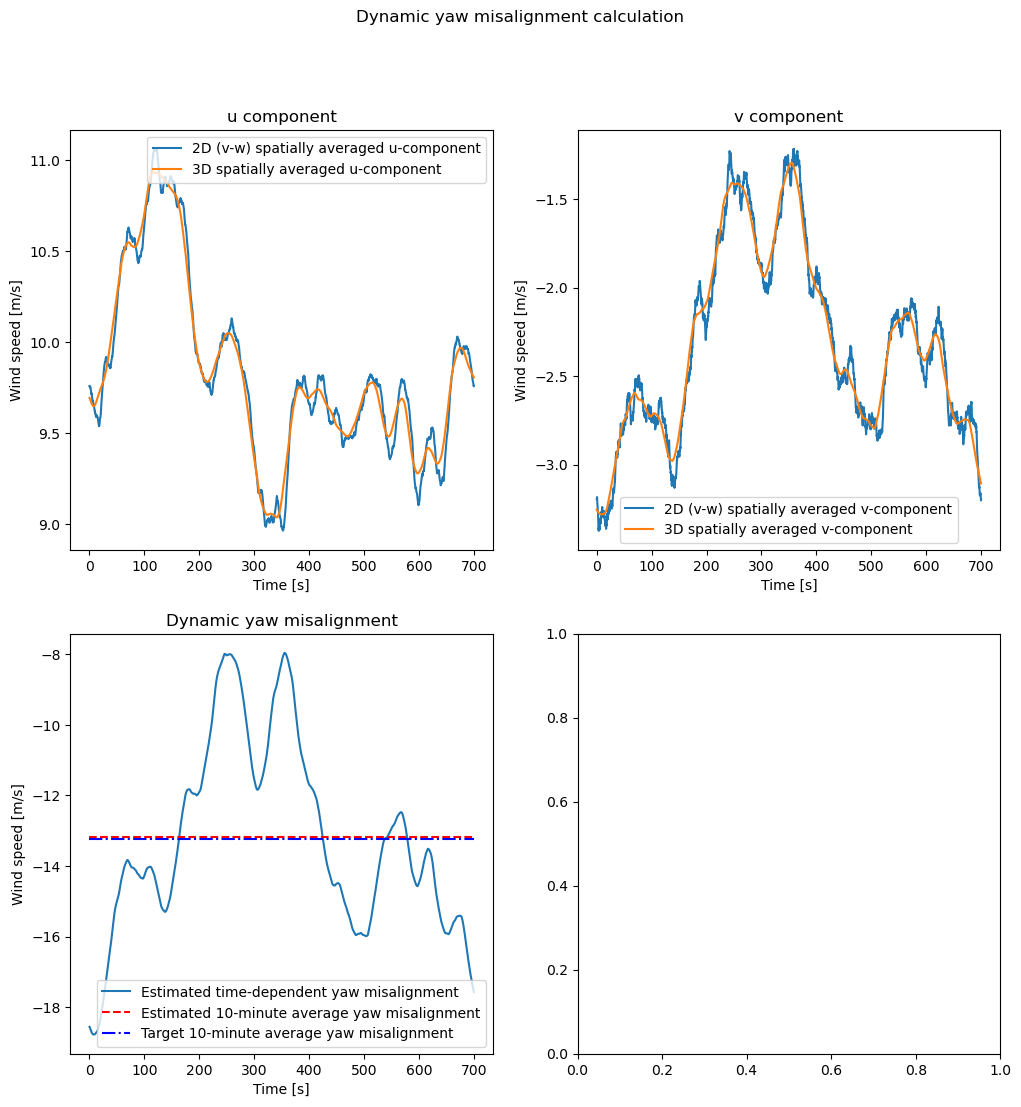

In [49]:
fig,ax = plt.subplots(2,2,figsize = (12,12))
ax[0,0].plot(Time,UplaneMeans, label = '2D (v-w) spatially averaged u-component')
ax[0,0].plot(Time,uave,label = '3D spatially averaged u-component')
ax[0,0].legend()
ax[0,0].set_xlabel('Time [s]')
ax[0,0].set_ylabel('Wind speed [m/s]')
ax[0,0].set_title('u component')
ax[0,1].plot(Time,VplaneMeans, label = '2D (v-w) spatially averaged v-component')
ax[0,1].plot(Time,vave,label = '3D spatially averaged v-component')
ax[0,1].legend()
ax[0,1].set_xlabel('Time [s]')
ax[0,1].set_ylabel('Wind speed [m/s]')
ax[0,1].set_title('v component')
ax[1,0].plot(Time,yawave,label = 'Estimated time-dependent yaw misalignment')
ax[1,0].plot([0, Time[-1]],[np.mean(yawave), np.mean(yawave)],'--r',label = 'Estimated 10-minute average yaw misalignment')
ax[1,0].plot([0, Time[-1]],[Yaw, Yaw],'-.b',label = 'Target 10-minute average yaw misalignment')
ax[1,0].legend()
ax[1,0].set_xlabel('Time [s]')
ax[1,0].set_ylabel('Wind speed [m/s]')
ax[1,0].set_title('Dynamic yaw misalignment')
fig.suptitle('Dynamic yaw misalignment calculation')
fig.savefig('Dynamic yaw misalignment calculation check.png')

In [9]:
# Import example time series data
SeriesData = pd.read_csv('c:/Users/nkdi/Documents/Studies/Surrogates/VirtualSensorsBenchmark/VS_benchmark_timeseries_PointNo1.csv', sep = ';')

In [10]:
SeriesData

,Time,Rotor azimuth [deg],Rotor rotational speed [rpm],Blade 1 pitch angle [deg],Blade 2 pitch angle [deg],Blade 3 pitch angle [deg],Generator LSS torque [Nm],Electrical power [W],Bedframe moment [Nm],Generator HSS torque [Nm],...,"Free wind speed Vx pos 55.00, 0.00, -95.00","Free wind speed Vy pos 55.00, 0.00, -95.00","Free wind speed Vz pos 55.00, 0.00, -95.00","Free wind speed Vx pos -55.00, 0.00,-205.00","Free wind speed Vy pos -55.00, 0.00,-205.00","Free wind speed Vz pos -55.00, 0.00,-205.00","Free wind speed Vx pos -55.00, 0.00, -95.00","Free wind speed Vy pos -55.00, 0.00, -95.00","Free wind speed Vz pos -55.00, 0.00, -95.00",Water surface elevation [m]
0,0.000000,0.112498,1.909839,0.000072,0.000072,0.000072,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,-4.498260,6.860258,-0.998191,-2.510331,9.455829,-0.348392,-2.570774,8.222809,-1.336728,0.615118
1,0.021875,0.224996,1.909839,0.000072,0.000072,0.000072,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,-4.484511,6.864519,-0.998570,-2.511524,9.459664,-0.325481,-2.579750,8.215022,-1.337528,0.623300
2,0.021875,0.348744,1.909839,0.000217,0.000217,0.000217,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,-4.470565,6.868780,-0.998874,-2.512546,9.463926,-0.302633,-2.588726,8.206826,-1.338329,0.631482
3,0.043750,0.461242,1.910322,0.000507,0.000507,0.000507,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,-4.456815,6.872615,-0.999253,-2.513569,9.467762,-0.279722,-2.597702,8.198629,-1.339196,0.639618
4,0.043750,0.573740,1.910806,0.001087,0.001087,0.001087,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,-4.443066,6.876876,-0.999556,-2.514591,9.472024,-0.256811,-2.606678,8.190842,-1.339997,0.647800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,699.956250,302.765867,7.502335,0.000507,0.000507,0.000507,-1.624668e+07,1.232449e+07,0.0,-1.624668e+07,...,-4.553455,8.000084,-0.953229,-2.542882,10.584851,-0.439661,-2.547171,9.419100,-1.251264,0.660773
69996,699.978125,303.227109,7.501851,0.000507,0.000507,0.000507,-1.624300e+07,1.232113e+07,0.0,-1.624300e+07,...,-4.543044,8.003067,-0.964375,-2.534531,10.590818,-0.422540,-2.550661,9.410903,-1.272413,0.665158
69997,699.978125,303.677101,7.501610,0.000507,0.000507,0.000507,-1.623871e+07,1.231730e+07,0.0,-1.623871e+07,...,-4.532634,8.006049,-0.975521,-2.526010,10.596358,-0.405482,-2.554318,9.402707,-1.293562,0.666966
69998,700.000000,304.127093,7.501126,0.000507,0.000507,0.000507,-1.623319e+07,1.231203e+07,0.0,-1.623319e+07,...,-4.522224,8.009032,-0.986742,-2.517659,10.601899,-0.388361,-2.557975,9.394920,-1.314711,0.668412


In [11]:
ChInfo = SeriesData.columns.values
ChInfo

array(['Time', 'Rotor azimuth [deg]', 'Rotor rotational speed [rpm]',
       'Blade 1 pitch angle [deg]', 'Blade 2 pitch angle [deg]',
       'Blade 3 pitch angle [deg]', 'Generator LSS torque [Nm]',
       'Electrical power [W]', 'Bedframe moment [Nm]',
       'Generator HSS torque [Nm]', 'Mudline moment Mx[kNm]',
       'Mudline moment My[kNm]', 'Mudline moment Mz[kNm]',
       'Waterline moment Mx[kNm]', 'Waterline moment My[kNm]',
       'Waterline moment Mz[kNm]', 'Tower base moment Mx[kNm]',
       'Tower base moment My[kNm]', 'Tower base moment Mz[kNm]',
       'Tower mid moment Mx[kNm]', 'Tower mid moment My[kNm]',
       'Tower mid moment Mz[kNm]', 'Tower top moment Mx[kNm]',
       'Tower top moment My[kNm]', 'Tower top moment Mz[kNm]',
       'Low-speed shaft torque [kNm]', 'Blade1 root moment Mx[kNm]',
       'Blade1 root moment My[kNm]', 'Blade1 root moment Mz[kNm]',
       'Blade2 root moment Mx[kNm]', 'Blade2 root moment My[kNm]',
       'Blade2 root moment Mz[kNm]', 'Bl

In [12]:
# IDENTIFY WINDSPEED CHANNELS FROM RESULT FILE
LocalWindChannelsX = np.asarray(np.argwhere([(('Free wind speed' in ChInfo[i]) & ('Vx' in ChInfo[i])) for i in range(len(ChInfo))]).squeeze(),dtype = 'int')
LocalWindChannelsY = np.asarray(np.argwhere([(('Free wind speed' in ChInfo[i]) & ('Vy' in ChInfo[i])) for i in range(len(ChInfo))]).squeeze(),dtype = 'int')
LocalWindChannelsZ = np.asarray(np.argwhere([(('Free wind speed' in ChInfo[i]) & ('Vz' in ChInfo[i])) for i in range(len(ChInfo))]).squeeze(),dtype = 'int')
TimeChannel = np.asarray(np.argwhere([('Time' in ChInfo[i]) for i in range(len(ChInfo))]).squeeze(),dtype = 'int')

In [13]:
# FIND COORDINATES OF POINTS FROM RESULT FILE
Nsteps = len(SeriesData.iloc[:,int(TimeChannel)])
dtsig = T/Nsteps
Time = np.arange(dtsig,T+dtsig,dtsig)
U = SeriesData.iloc[:,LocalWindChannelsY]
X = np.zeros(len(LocalWindChannelsY))
Y = np.zeros(len(LocalWindChannelsY))
Z = np.zeros(len(LocalWindChannelsY))

for i in range(len(LocalWindChannelsY)):
    stri = ChInfo[LocalWindChannelsY[i]].split('pos')[1].split(',')
    X[i] = float(list(filter(None,stri[0].split(' ')))[0])
    Y[i] = float(list(filter(None,stri[1].split(' ')))[0])
    Z[i] = float(list(filter(None,stri[2].split(' ')))[0])    

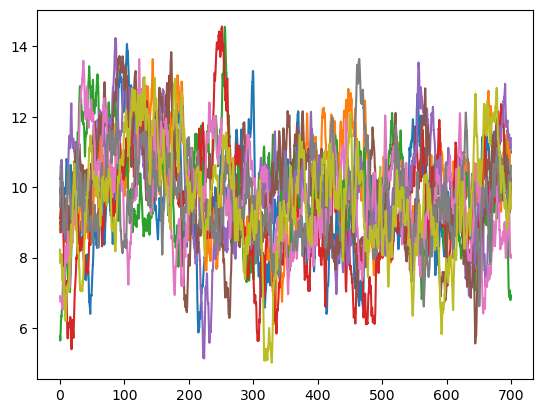

In [14]:
# JUST PLOT TIME SERIES FOR VISUALIZATION
plt.plot(Time,U)
plt.show()

In [15]:
# EXTRACT TURBULENCE TIME SERIES FROM TURBULENCE BOX

u0points = (Time,np.ones(len(Time))*X[0],np.ones(len(Time))*Z[0])
u1points = (Time,np.ones(len(Time))*X[1],np.ones(len(Time))*Z[1])
u2points = (Time,np.ones(len(Time))*X[2],np.ones(len(Time))*Z[2])
u3points = (Time,np.ones(len(Time))*X[3],np.ones(len(Time))*Z[3])
u4points = (Time,np.ones(len(Time))*X[4],np.ones(len(Time))*Z[4])

u0 = Hawc2FieldSample(u0points, u, du, dv, dw, Xhub, Zhub, T = T, Umean=0, alpha=0, TI=None)
u1 = Hawc2FieldSample(u1points, u, du, dv, dw, Xhub, Zhub, T = T, Umean=0, alpha=0, TI=None)
u2 = Hawc2FieldSample(u2points, u, du, dv, dw, Xhub, Zhub, T = T, Umean=0, alpha=0, TI=None)
u3 = Hawc2FieldSample(u3points, u, du, dv, dw, Xhub, Zhub, T = T, Umean=0, alpha=0, TI=None)
u4 = Hawc2FieldSample(u4points, u, du, dv, dw, Xhub, Zhub, T = T, Umean=0, alpha=0, TI=None)


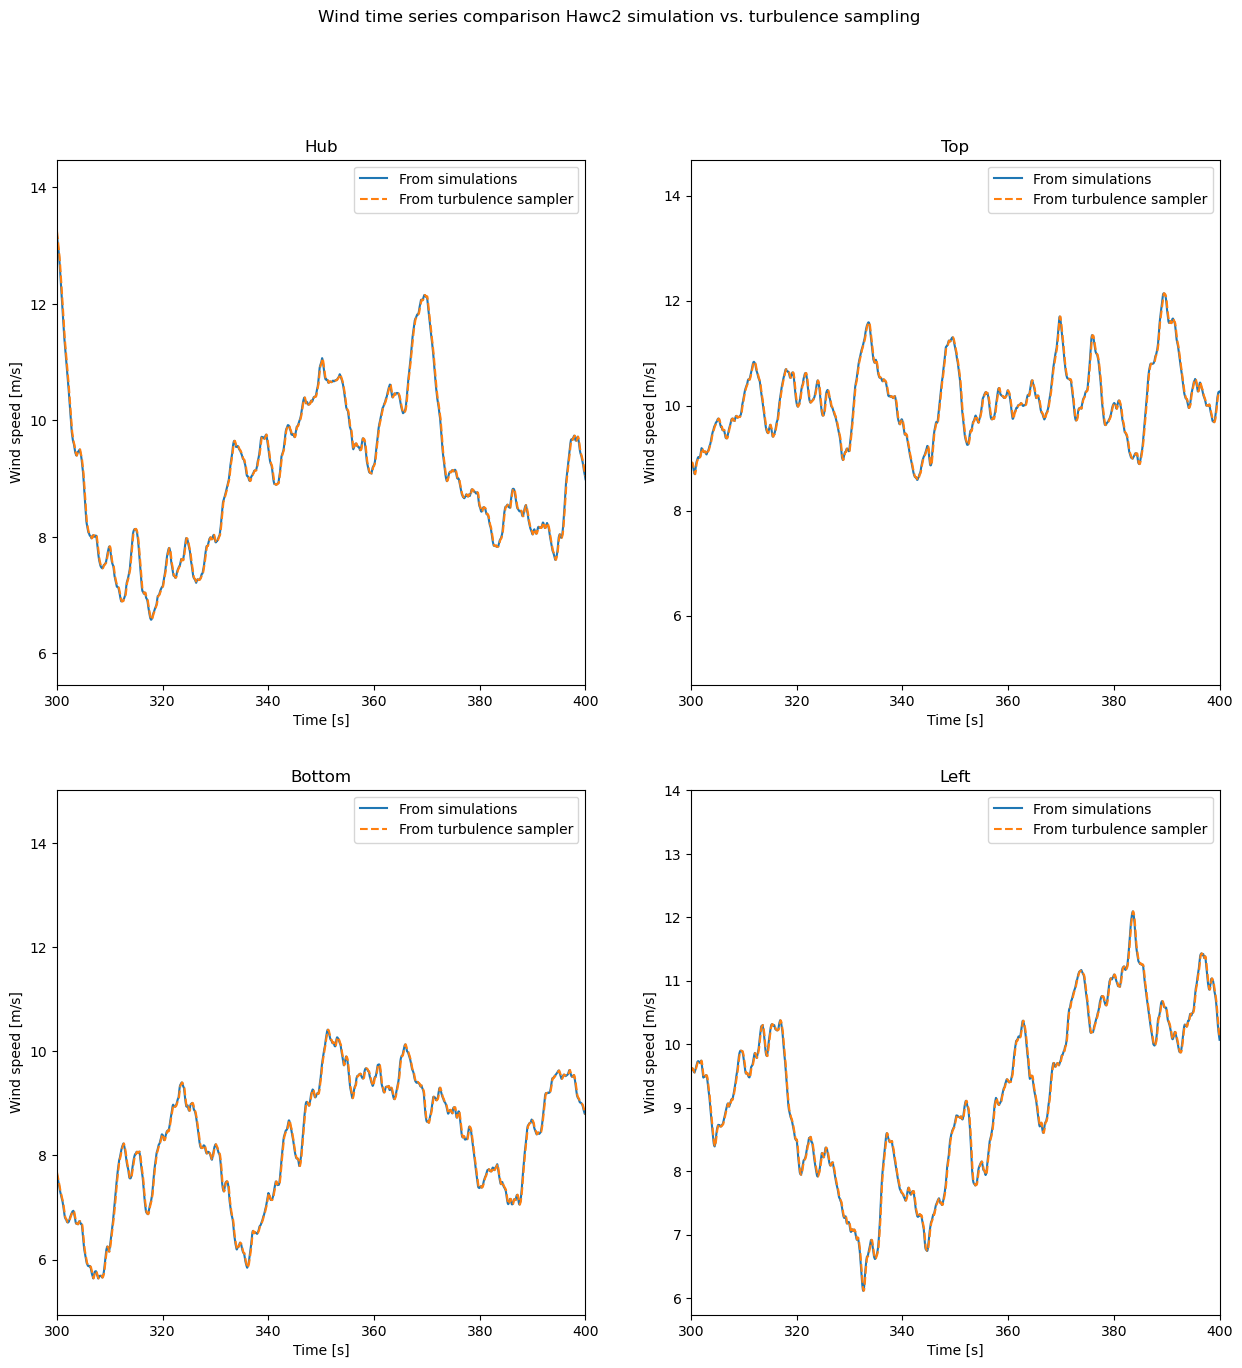

In [22]:
# PLOT COMPARISON
fig,ax = plt.subplots(2,2,figsize = (15,15))
ax[0,0].plot(Time,U.iloc[:,0], label = 'From simulations')
ax[0,0].plot(Time,u0,'--', label = 'From turbulence sampler')
ax[0,0].set_xlim((300,400))
ax[0,0].set_xlabel('Time [s]')
ax[0,0].set_ylabel('Wind speed [m/s]')
ax[0,0].set_title('Hub')
ax[0,0].legend()
ax[0,1].plot(Time,U.iloc[:,4], label = 'From simulations')
ax[0,1].plot(Time,u4,'--', label = 'From turbulence sampler')
ax[0,1].set_xlim((300,400))
ax[0,1].set_xlabel('Time [s]')
ax[0,1].set_ylabel('Wind speed [m/s]')
ax[0,1].set_title('Top')
ax[0,1].legend()
ax[1,0].plot(Time,U.iloc[:,3], label = 'From simulations')
ax[1,0].plot(Time,u3,'--', label = 'From turbulence sampler')
ax[1,0].set_xlim((300,400))
ax[1,0].set_xlabel('Time [s]')
ax[1,0].set_ylabel('Wind speed [m/s]')
ax[1,0].set_title('Bottom')
ax[1,0].legend()
ax[1,1].plot(Time,U.iloc[:,1], label = 'From simulations')
ax[1,1].plot(Time,u1,'--', label = 'From turbulence sampler')
ax[1,1].set_xlim((300,400))
ax[1,1].set_xlabel('Time [s]')
ax[1,1].set_ylabel('Wind speed [m/s]')
ax[1,1].set_title('Left')
ax[1,1].legend()
fig.suptitle('Wind time series comparison Hawc2 simulation vs. turbulence sampling')
plt.show()
fig.savefig('Time series overlap.png')